In [1]:
import os
import pandas as pd
import re 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata
from tqdm.auto import tqdm
# from rapidfuzz import process, fuzz
pd.set_option('display.max_colwidth', 200)

pd.options.display.max_rows = 339
pd.options.display.max_columns = 339

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('../../../PMC-Patients-V2.pkl')

In [3]:
df[['patient_id','patient_uid','PMID']].nunique()

patient_id     250294
patient_uid    250294
PMID           210069
dtype: int64

In [4]:
pop_ids = df['PMID'].value_counts()[df['PMID'].value_counts()>=5].index.tolist()

In [5]:
df_main = df[df.PMID.isin(pop_ids)].reset_index(drop=True)

In [6]:
len(pop_ids)

2015

In [7]:
df_main.shape

(12249, 9)

In [8]:
df_main[['patient_id','patient_uid','PMID']].nunique()

patient_id     12249
patient_uid    12249
PMID            2015
dtype: int64

In [9]:
## Clastering with LLM
groups = {
  "Traumatic-event headaches": "Neurology & Psychiatry",
  "Outcome of infections due to pandrug-resistant (PDR) Gram-negative bacteria": "Infectious Diseases & Immunology",
  "Paradise – not without its plagues: Overwhelming Blastomycosis pneumonia after visit to lakeside cottages in Northeastern Ontario": "Infectious Diseases & Immunology",
  "Complications during pharmacological stress echocardiography: a video-case series": "Cardiovascular & Pulmonary Diseases",
  "Homocysteine and cognitive impairment; a case series in a General Practice setting": "Neurology & Psychiatry",
  "Eating dysfunction associated with oromandibular dystonia: clinical characteristics and treatment considerations": "Neurology & Psychiatry",
  "Successful pulmonary administration of activated recombinant factor VII in diffuse alveolar hemorrhage": "Cardiovascular & Pulmonary Diseases",
  "Intramuscular Olanzapine – a UK case series of early cases": "Pharmacology, Toxicology & Adverse Effects",
  "A pilot study of IL-1 inhibition by anakinra in acute gout": "Musculoskeletal, Trauma & Rheumatology",
  "Thyroid cancer causing obstruction of the great veins in the neck": "Oncology",
  "Late Gadolinium Enhancement of the right ventricular myocardium: Is it really different from the left ?": "Diagnostics, Imaging & Pathology",
  "Experience with recipient splenic artery inflow in adult liver transplantation: a case series": "Surgery, Procedures & Transplantation",
  "Thumb reconstruction by grafting skeletonized amputated phalanges and soft tissue cover – A new technique: A case series": "Surgery, Procedures & Transplantation",
  "Ultrastructural pathology of nephropathies with organized deposits: a case series": "Urology & Nephrology",
  "Special problems encountering surgical management of large retroperitoneal schwannomas": "Oncology",
  "The middle house or the middle floor: Bisecting horizontal and vertical mental number lines in neglect": "Neurology & Psychiatry",
  "Restricted Diffusion in the Splenium of the Corpus Callosum After Cardiac Arrest": "Neurology & Psychiatry",
  "Outcome of protease inhibitor substitution with nevirapine in HIV-1 infected children": "Infectious Diseases & Immunology",
  "Report from Mongolia – How much do we know about the incidence of rare cases in less developed countries: a case series": "Public Health, Epidemiology & Case Reports/Series (General)",
  "Mutations in the Plasmodium falciparum cytochrome b gene are associated with delayed parasite recrudescence in malaria patients treated with atovaquone-proguanil": "Infectious Diseases & Immunology",
  "Genetic variations in the hotspot region of RS1 gene in Indian patients with juvenile X-linked retinoschisis": "Genetic, Congenital & Developmental Disorders",
  "Genitourinary rhinosporidiosis": "Infectious Diseases & Immunology",
  "Subtelomeric FISH analysis in 76 patients with syndromic developmental delay/intellectual disability": "Genetic, Congenital & Developmental Disorders",
  "Laparoscopic cholecystectomy during pregnancy: A case series": "Surgery, Procedures & Transplantation",
  "Flinders Island Spotted Fever Rickettsioses Caused by “marmionii” Strain of Rickettsia honei, Eastern Australia": "Infectious Diseases & Immunology",
  "Mutations in STK11 gene in Czech Peutz-Jeghers patients": "Genetic, Congenital & Developmental Disorders",
  "Prehospital Use of the Intubating Laryngeal Mask Airway in Patients with Severe Polytrauma: A Case Series": "Surgery, Procedures & Transplantation",
  "Immediate breast reconstruction following segmentectomy using a latissimus dorsi ‘myoadipose’ flap through a single axillary incision: a case series": "Surgery, Procedures & Transplantation",
  "A study of the use of the supraclavicular artery flap for resurfacing of head, neck, and upper torso defects": "Surgery, Procedures & Transplantation",
  "Neuro-ophthalmic Afferent System Diagnoses A General Ophthalmologist Should (Almost) Never Make Alone": "Neurology & Psychiatry",
  "Fasting and cancer treatment in humans: A case series report": "Oncology",
  "Ultrasound-guided nerve blocks in the emergency department": "Diagnostics, Imaging & Pathology",
  "Neurofibromatosis of the nipple-areolar area: a case series": "Genetic, Congenital & Developmental Disorders",
  "Rituximab for the treatment of refractory pediatric autoimmune diseases: a case series": "Infectious Diseases & Immunology",
  "Subarachnoidal Neurocysticercosis non-responsive to cysticidal drugs: a case series": "Infectious Diseases & Immunology",
  "Primary treatment of acromegaly with high-dose lanreotide: a case series": "Endocrinology, Metabolism & Nutrition",
  "Rehabilitation using single stage implants": "Surgery, Procedures & Transplantation",
  "Case Report: Lung Disease in World Trade Center Responders Exposed to Dust and Smoke: Carbon Nanotubes Found in the Lungs of World Trade Center Patients and Dust Samples": "Cardiovascular & Pulmonary Diseases",
  "Burkholderia pseudomallei musculoskeletal infections (melioidosis) in India": "Infectious Diseases & Immunology",
  "Molecular defects in the mannose binding lectin pathway in dermatological disease: Case report and literature review": "Infectious Diseases & Immunology",
  "Fluvoxamine for blonanserin-associated akathisia in patients with schizophrenia: report of five cases": "Neurology & Psychiatry",
  "Sigma-1 receptor agonist fluvoxamine for delirium in intensive care units: report of five cases": "Neurology & Psychiatry",
  "Rhinorrhea, cough and fatigue in patients taking sitagliptin": "Pharmacology, Toxicology & Adverse Effects",
  "Diagnostic difficulties and pitfalls in rapid on-site evaluation of endobronchial ultrasound guided fine needle aspiration": "Diagnostics, Imaging & Pathology",
  "Different phenotypes of lattice corneal dystrophy type I in patients with 417C>T (R124C) and 1762A>G (H572R) mutations in TGFBI (BIGH3)": "Genetic, Congenital & Developmental Disorders",
  "Pleural effusion following ventriculopleural shunt: Case reports and review of the literature": "Neurology & Psychiatry",
  "An analysis of six cases of acute intermittent porphyria (AIP)": "Genetic, Congenital & Developmental Disorders",
  "Gamma knife radiosurgery of meningiomas involving the foramen magnum": "Oncology",
  "Dislocation following total knee arthroplasty: A report of six cases": "Musculoskeletal, Trauma & Rheumatology",
  "Carbon ion radiotherapy for basal cell adenocarcinoma of the head and neck: preliminary report of six cases and review of the literature": "Oncology",
  "Endemic Gastrointestinal Anthrax in 1960s Lebanon: Clinical Manifestations and Surgical Findings": "Infectious Diseases & Immunology",
  "Radio-induced malignancies after breast cancer postoperative radiotherapy in patients with Li-Fraumeni syndrome": "Oncology",
  "Therapeutic misadventure with paracetamol in children": "Pharmacology, Toxicology & Adverse Effects",
  "Acute Flaccid Paralysis and West Nile Virus Infection": "Infectious Diseases & Immunology",
  "Emerging Infections: Shewanella – A Series of Five Cases": "Infectious Diseases & Immunology",
  "Cholestasis in patients with Cockayne syndrome and suggested modified criteria for clinical diagnosis": "Genetic, Congenital & Developmental Disorders",
  "A color spectrographic phonocardiography (CSP) applied to the detection and characterization of heart murmurs: preliminary results": "Diagnostics, Imaging & Pathology",
  "Sclerosing Mesenteritis: Diverse clinical presentations and dissimilar treatment options. A case series and review of the literature": "Gastroenterology & Hepatology",
  "Parenteral lidocaine for treatment of intractable renal colic: a case series": "Urology & Nephrology",
  "c.194 A>C (Q65P) mutation in the LMX1B gene in patients with nail-patella syndrome associated with glaucoma": "Genetic, Congenital & Developmental Disorders",
  "Systemic Lupus Erythematosus and Systemic Autoimmune Connective Tissue Disorders behind Recurrent Diastolic Heart Failure": "Infectious Diseases & Immunology",
  "Prognosis of West Nile virus associated acute flaccid paralysis: a case series": "Infectious Diseases & Immunology",
  "Bacillus Calmette-Guérin-related cold thigh abscess as an unusual cause of thigh swelling in infants following BCG vaccine administration: a case series": "Infectious Diseases & Immunology",
  "Hyperacute Corticosteroid Treatment of Optic Neuritis at the Onset of Pain May Prevent Visual Loss: A Case Series": "Ophthalmology",
  "Partial anomalous pulmonary venous return and atrial septal defect in adult patients detected with 128-slice multidetector computed tomography": "Cardiovascular & Pulmonary Diseases",
  "Surgical treatment for pulmonary metastases from esophageal carcinoma after definitive chemoradiotherapy: Experience from a single institution": "Oncology",
  "Gaslini's tracheal team: preliminary experience after one year of paediatric airway reconstructive surgery": "Surgery, Procedures & Transplantation",
  "Digital Subtraction Phonocardiography (DSP) applied to the detection and characterization of heart murmurs": "Diagnostics, Imaging & Pathology",
  "Sellar and Parasellar Metastatic Tumors": "Oncology",
  "A Classification System in the Massive Weight Loss Patient Based on Skin Lesions and Activity of Daily Living": "Surgery, Procedures & Transplantation",
  "Various clinical scenarios leading to development of the string sign of the internal thoracic artery after coronary bypass surgery: the role of competitive flow, a case series": "Cardiovascular & Pulmonary Diseases",
  "Emergence of Blastoschizomyces capitatus Yeast Infections, Central Europe": "Infectious Diseases & Immunology",
  "Septic Arthritis in Rheumatology: Review of Five Cases": "Infectious Diseases & Immunology",
  "Pseudoseptic Arthritis: A Case Series and Review of the Literature": "Musculoskeletal, Trauma & Rheumatology",
  "Primary Maxillofacial Large B-Cell Lymphoma in Immunocompetent Patients: Report of 5 Cases": "Oncology",
  "Eyelid Carcinoma in Patients with Systemic Lymphoma": "Oncology",
  "Emergency total thyroidectomy due to non traumatic disease. Experience of a surgical unit and literature review": "Surgery, Procedures & Transplantation",
  "Longitudinal Deformation-Based Morphometry Reveals Spatio-Temporal Dynamics of Brain Volume Changes in Patients with Corticobasal Syndrome": "Diagnostics, Imaging & Pathology",
  "Idiopathic accelerated gastric emptying presenting in adults with post-prandial diarrhea and reactive hypoglycemia: a case series": "Gastroenterology & Hepatology",
  "Noninvasive Evaluation of Nuclear Morphometry in Breast Lesions Using Multispectral Diffuse Optical Tomography": "Diagnostics, Imaging & Pathology",
  "Complement factor I deficiency: a not so rare immune defect. Characterization of new mutations and the first large gene deletion": "Infectious Diseases & Immunology",
  "Flatfoot in Müller-Weiss syndrome: a case series": "Musculoskeletal, Trauma & Rheumatology",
  "Vasculitic emergencies in the intensive care unit: a special focus on cryoglobulinemic vasculitis": "Infectious Diseases & Immunology",
  "18 F-fluoro-deoxy-glucose focal uptake in very small pulmonary nodules: fact or artifact? Case reports": "Diagnostics, Imaging & Pathology",
  "Long-term evolution of Valsalva retinopathy: a case series": "Ophthalmology",
  "Granular cell tumors: a report of six cases": "Oncology",
  "Clinical features of delirious mania: a series of five cases and a brief literature review": "Neurology & Psychiatry",
  "Hypopigmented Mycosis Fungoides in Type V Skin: A Report of 5 Cases": "Dermatology",
  "Imaging Review of Neurofibromatosis: Helpful Aspects for Early Detection": "Diagnostics, Imaging & Pathology",
  "Radiological Features of Osteoid Osteoma: Pictorial Review": "Diagnostics, Imaging & Pathology",
  "Bony Lesions in Pediatric Acute Leukemia: Pictorial Essay": "Diagnostics, Imaging & Pathology",
  "The Price of Tumor Control: An Analysis of Rare Side Effects of Anti-CTLA-4 Therapy in Metastatic Melanoma from the Ipilimumab Network": "Pharmacology, Toxicology & Adverse Effects",
  "Modified Valsalva test differentiates primary from secondary cough headache": "Diagnostics, Imaging & Pathology",
  "Lassa fever presenting as acute abdomen: a case series": "Infectious Diseases & Immunology",
  "Limb Amputations in Fixed Dystonia: A Form of Body Integrity Identity Disorder?": "Neurology & Psychiatry",
  "Haploinsufficiency of two histone modifier genes on 6p22.3, ATXN1 and JARID2, is associated with intellectual disability": "Genetic, Congenital & Developmental Disorders",
  "Gastroesophageal reflux in Bronchiectasis and the effect of anti-reflux treatment": "Cardiovascular & Pulmonary Diseases",
  "COG5-CDG: expanding the clinical spectrum": "Genetic, Congenital & Developmental Disorders",
  "Repetitive Transcranial Magnetic Stimulation to Maintain Treatment Response to Electroconvulsive Therapy in Depression: A Case Series": "Neurology & Psychiatry",
  "Optic Radiation Fiber Tractography in Glioma Patients Based on High Angular Resolution Diffusion Imaging with Compressed Sensing Compared with Diffusion Tensor Imaging - Initial Experience": "Diagnostics, Imaging & Pathology",
  "Computed Tomography Angiography in Microsurgery: Indications, Clinical Utility, and Pitfalls": "Diagnostics, Imaging & Pathology",
  "Image Quality Improvement in Adaptive Optics Scanning Laser Ophthalmoscopy Assisted Capillary Visualization Using B-spline-based Elastic Image Registration": "Diagnostics, Imaging & Pathology",
  "Rapidly progressive dementia with thalamic degeneration and peculiar cortical prion protein immunoreactivity, but absence of proteinase K resistant PrP: a new disease entity?": "Neurology & Psychiatry",
  "Effect of blockade of the EGF system on wound healing in patients vaccinated with CIMAvax® EGF": "Pharmacology, Toxicology & Adverse Effects",
  "MAN1B1 Deficiency: An Unexpected CDG-II": "Genetic, Congenital & Developmental Disorders",
  "Combined computed tomography and fluorodeoxyglucose positron emission tomography in the diagnosis of prosthetic valve endocarditis: a case series": "Diagnostics, Imaging & Pathology",
  "In Subfertile Couple, Abdominal Fat Loss in Men Is Associated with Improvement of Sperm Quality and Pregnancy: A Case-Series": "Obstetrics, Gynecology & Reproductive Health",
  "Primary nodal anthracosis identified by EBUS-TBNA as a cause of FDG PET/CT positive mediastinal lymphadenopathy": "Diagnostics, Imaging & Pathology",
  "Nested Variant of Urothelial Carcinoma": "Oncology",
  "Five Cases of Non-Hodgkin B-Cell Lymphoma of the Ovary": "Oncology",
  "Non-islet cell tumor-induced hypoglycemia: a report of five cases and brief review of the literature": "Oncology",
  "Streptococcus acidominimus causing invasive disease in humans: a case series": "Infectious Diseases & Immunology",
  "Glycogen Storage Disease type 1a – a secondary cause for hyperlipidemia: report of five cases": "Endocrinology, Metabolism & Nutrition",
  "Adult Hip Flexion Contracture due to Neurological Disease: A New Treatment Protocol—Surgical Treatment of Neurological Hip Flexion Contracture": "Neurology & Psychiatry",
  "Role of multi-detector computed tomography (MDCT) in management of post percutaneous nephrolithotomy (PCNL) bleeding": "Diagnostics, Imaging & Pathology",
  "Radioiodine Contamination Artifacts and Unusual Patterns of Accumulation in Whole-body I-131 Imaging: A Case Series": "Diagnostics, Imaging & Pathology",
  "Upper Extremity Thrombosis Presenting as Medial Elbow Pain after Shoulder Arthroscopy": "Cardiovascular & Pulmonary Diseases",
  "A Case Series of Emphysematous Pyelonephritis": "Urology & Nephrology",
  "Profound CD4+ T lymphocytopenia in human immunodeficiency virus negative individuals, improved with anti-human herpes virus treatment": "Infectious Diseases & Immunology",
  "Orbital and adnexal tuberculosis: a case series from a South Indian population": "Infectious Diseases & Immunology",
  "Possible Association of Etanercept, Venous Thrombosis, and Induction of Antiphospholipid Syndrome": "Pharmacology, Toxicology & Adverse Effects",
  "Breast vibro-acoustography: initial results show promise": "Diagnostics, Imaging & Pathology",
  "Hypokalaemia-Induced Rhabdomyolysis after Treatment of Post-Kala-azar Dermal Leishmaniasis (PKDL) with High-Dose AmBisome in Bangladesh—A Case Report": "Pharmacology, Toxicology & Adverse Effects",
  "Apnea-hypopnea index use among intensive care patients: a case series": "Cardiovascular & Pulmonary Diseases",
  "Hearing impairment and audiovisual speech integration ability: a case study report": "Neurology & Psychiatry",
  "Management of significant reactivation of old disciform scars in wet Age-Related Macular Degeneration": "Ophthalmology",
  "Cytological features of pure micropapillary carcinoma of various organs: A report of eight cases": "Oncology",
  "Comparative Study of Dentinogenesis": "Genetic, Congenital & Developmental Disorders",
  "Imperfecta in Different Families of the Same": "Genetic, Congenital & Developmental Disorders",
  "Topographical Region": "Public Health, Epidemiology & Case Reports/Series (General)",
  "Use of Mineral Trioxide Aggregate in Surgical and Conventional Endodontics: A Report of Five Cases": "Surgery, Procedures & Transplantation",
  "Influence of Herbal Complexes Containing Licorice on Potassium Levels: A Retrospective Study": "Pharmacology, Toxicology & Adverse Effects",
  "Tuboplasty as a reversal macrosurgery for tubal ligation, is pregnancy possible? A case series": "Surgery, Procedures & Transplantation",
  "Unloading of Right Ventricle and Clinical Improvement after Ultrasound-Accelerated Thrombolysis in Patients with Submassive Pulmonary Embolism": "Cardiovascular & Pulmonary Diseases",
  "Array-CGH analysis in Rwandan patients presenting development delay/intellectual disability with multiple congenital anomalies": "Genetic, Congenital & Developmental Disorders",
  "A case series of Meckel’s diverticulum: usefulness of double-balloon enteroscopy for diagnosis": "Gastroenterology & Hepatology",
  "Maxillofacial Trauma in Children": "Musculoskeletal, Trauma & Rheumatology",
  "Hyperleukocytosis: A report of five cases and review of the literature": "Oncology",
  "Rapid response to systemic bevacizumab therapy in recurrent respiratory papillomatosis": "Oncology",
  "Ipilimumab administration for advanced melanoma in patients with pre-existing Hepatitis B or C infection: a multicenter, retrospective case series": "Oncology",
  "Localization of Interictal Epileptiform Activity Using Magnetoencephalography with Synthetic Aperture Magnetometry in Patients with a Vagus Nerve Stimulator": "Diagnostics, Imaging & Pathology",
  "The use of CorMatrix extracellular matrix for aortic root enlargement": "Surgery, Procedures & Transplantation",
  "Open Access Integrated Therapeutic and Diagnostic Platforms for Personalized Cardiovascular Medicine": "Diagnostics, Imaging & Pathology",
  "Treatment Algorithm for Ameloblastoma": "Oncology",
  "Interstitial Lung Disease Associated with mTOR Inhibitors in Solid Organ Transplant Recipients: Results from a Large Phase III Clinical Trial Program of Everolimus and Review of the Literature": "Pharmacology, Toxicology & Adverse Effects",
  "Case series discussion of cardiac and vascular events following carfilzomib treatment: possible mechanism, screening, and monitoring": "Pharmacology, Toxicology & Adverse Effects",
  "Chemotherapy for anaplastic thyroid cancer using docetaxel and cisplatin: report of eight cases": "Oncology",
  "Post-surgical surveillance of locally advanced ileal carcinoids found by routine ileal intubation during screening colonoscopy: a case series": "Oncology",
  "Two-year follow-up of revision total hip arthroplasty using a ceramic revision head with a retained well-fixed femoral component: a case series": "Musculoskeletal, Trauma & Rheumatology",
  "Exercise-induced seizures and lateral asymmetry in patients with temporal lobe epilepsy": "Neurology & Psychiatry",
  "Association of ANCA associated vasculitis and rheumatoid arthritis: a lesser recognized overlap syndrome": "Infectious Diseases & Immunology",
  "Case Reports That Illustrate the Efficacy of SGLT2 Inhibitors in the Type 1 Diabetic Patient": "Endocrinology, Metabolism & Nutrition",
  "Clinical case presentation and a review of the literature of canine onchocercosis by Onchocerca lupi in the United States": "Infectious Diseases & Immunology",
  "Allergy to cooked, but not raw, peas: a case series and review": "Infectious Diseases & Immunology",
  "In-bag dislocation of intraocular lens in patients with uveitis: a case series": "Ophthalmology",
  "The Bipolar Depression Electrical Treatment Trial (BETTER): Design, Rationale, and Objectives of a Randomized, Sham-Controlled Trial and Data from the Pilot Study Phase": "Neurology & Psychiatry",
  "Congenital Midureteric Stricture: Challenges in Diagnosis and Management": "Urology & Nephrology",
  "Moyamoya disease and pregnancy: case reports and criteria for successful vaginal delivery": "Neurology & Psychiatry",
  "Surgical Treatment for Profunda Femoris Artery Aneurysms: Five Case Reports": "Cardiovascular & Pulmonary Diseases",
  "Intoxication due to Papaver rhoeas (Corn Poppy): Five Case Reports": "Pharmacology, Toxicology & Adverse Effects",
  "Using the Neuroadaptagen KB200z™ to Ameliorate Terrifying, Lucid Nightmares in RDS Patients: the Role of Enhanced, Brain-Reward, Functional Connectivity and Dopaminergic Homeostasis": "Pharmacology, Toxicology & Adverse Effects",
  "Kartagener’s syndrome: review of a case series": "Genetic, Congenital & Developmental Disorders",
  "Characteristics and Treatment Results of 5 Patients with Fibrous Dysplasia and Review of the Literature": "Genetic, Congenital & Developmental Disorders",
  "Unusual skin manifestation of hand, foot and mouth disease associated with coxsackievirus A6: cases report": "Infectious Diseases & Immunology",
  "An in vitro test bench reproducing coronary blood flow signals": "Diagnostics, Imaging & Pathology",
  "Surgical Treatment of Cystic Adventitial Disease of the Popliteal Artery: Five Case Reports": "Cardiovascular & Pulmonary Diseases",
  "Deaths and Severe Adverse Events Associated with Anesthesia-Assisted Rapid Opioid Detoxification — New York City, 2012": "Pharmacology, Toxicology & Adverse Effects",
  "Clinical Application of Multigene Panels: Challenges of Next-Generation Counseling and Cancer Risk Management": "Genetic, Congenital & Developmental Disorders",
  "Therapeutic approach to Class II, Division 1 malocclusion with maxillary functional orthopedics": "Surgery, Procedures & Transplantation",
  "Value of Nerve Biopsy in Patients With Latent Malignant Hemopathy and Peripheral Neuropathy": "Diagnostics, Imaging & Pathology",
  "Extra- and Intracranial Cerebral Vasculitis in Giant Cell Arteritis": "Infectious Diseases & Immunology",
  "Movement and Other Neurodegenerative Syndromes in Patients with Systemic Rheumatic Diseases": "Neurology & Psychiatry",
  "Mirror neuron system based therapy for aphasia rehabilitation": "Neurology & Psychiatry",
  "Rituximab-induced interstitial lung disease: five case reports": "Pharmacology, Toxicology & Adverse Effects",
  "Invasive cutaneous Neoscytalidium infections in renal transplant recipients: a series of five cases": "Infectious Diseases & Immunology",
  "The Libyan civil conflict: selected case series of orthopaedic trauma managed in Malta in 2014": "Musculoskeletal, Trauma & Rheumatology",
  "Clinical manifestations and endoscopic findings of amebic colitis in a United States-Mexico border city: a case series": "Infectious Diseases & Immunology",
  "Reconstructive surgery in immunocompromised patients: evaluation and therapy": "Surgery, Procedures & Transplantation",
  "Tubulointerstitial nephritis in primary Sjögren syndrome: clinical manifestations and response to treatment": "Urology & Nephrology",
  "POGZ truncating alleles cause syndromic intellectual disability": "Genetic, Congenital & Developmental Disorders",
  "Extraneural hemangioblastoma of the kidney: the challenge for clinicopathological diagnosis": "Oncology",
  "Treatment Failure after Multiple Courses of Triclabendazole among Patients with Fascioliasis in Cusco, Peru: A Case Series": "Infectious Diseases & Immunology",
  "Perineural Injection for Treatment of Root-Signature Signs Associated with Lateralized Disk Material in Five Dogs (2009–2013)": "Musculoskeletal, Trauma & Rheumatology",
  "An Overview of Insulin Pumps and Glucose Sensors for the Generalist": "Endocrinology, Metabolism & Nutrition",
  "High recurrence rate supports need for secondary prophylaxis in non-HIV patients with disseminated mycobacterium avium complex infection: a multi-center observational study": "Infectious Diseases & Immunology",
  "Sofosbuvir and Simeprevir for the Treatment of Recurrent Hepatitis C with Fibrosing Cholestatic Hepatitis after Liver Transplantation": "Infectious Diseases & Immunology",
  "Psoas tunnel perforation—an unreported complication of hip arthroscopy": "Musculoskeletal, Trauma & Rheumatology",
  "Mechanisms and Clinical Management of Ventricular Arrhythmias following Blunt Chest Trauma": "Cardiovascular & Pulmonary Diseases",
  "Methylotroph Infections and Chronic Granulomatous Disease": "Infectious Diseases & Immunology",
  "Ultrasound-guided thrombin injection for treatment of superficial traumatic pseudoaneurysms and associated expanding hematomas: experience in five patients": "Cardiovascular & Pulmonary Diseases",
  "Clinical and immunological data of nine patients with chronic mucocutaneous candidiasis disease": "Infectious Diseases & Immunology",
  "Diving accidents: a cohort study from the Netherlands": "Musculoskeletal, Trauma & Rheumatology",
  "Inhalational Alzheimer's disease: an unrecognized—and treatable—epidemic": "Neurology & Psychiatry",
  "Deletions and de novo mutations of SOX11 are associated with a neurodevelopmental disorder with features of Coffin–Siris syndrome": "Genetic, Congenital & Developmental Disorders",
  "Primary brain calcification in patients undergoing treatment with the biphosphanate alendronate": "Neurology & Psychiatry",
  "Phenotype and genotype in patients with Larsen syndrome: clinical homogeneity and allelic heterogeneity in seven patients": "Genetic, Congenital & Developmental Disorders",
  "The Identification of Microdeletion and Reciprocal Microduplication in 22q11.2 Using High-Resolution CMA Technology": "Genetic, Congenital & Developmental Disorders",
  "The risk of intra-urethral Foley catheter balloon inflation in spinal cord-injured patients: Lessons learned from a retrospective case series": "Urology & Nephrology",
  "Azathioprine therapy for steroid-resistant Henoch-Schönlein purpura: a report of 6 cases": "Infectious Diseases & Immunology",
  "Reversal of cognitive decline in Alzheimer's disease": "Neurology & Psychiatry",
  "Novel de novo missense mutations causing epilepsy and intellectual disability": "Genetic, Congenital & Developmental Disorders",
  "Takotsubo Cardiomyopathy: Case Series and Literature Review": "Cardiovascular & Pulmonary Diseases",
  "Genotype-phenotype analysis of von Hippel-Lindau syndrome in Korean families: HIF-α binding site missense mutations elevate age-specific risk for CNS hemangioblastoma": "Genetic, Congenital & Developmental Disorders",
  "Epithelioid inflammatory myofibroblastic sarcoma: a clinicopathological, immunohistochemical and molecular cytogenetic analysis of five additional cases and review of the literature": "Oncology",
  "Cardiotoxicity associated with CTLA4 and PD1 blocking immunotherapy": "Pharmacology, Toxicology & Adverse Effects",
  "Mono-sensitisation to peanut component Ara h 6: a case series of five children and literature review": "Infectious Diseases & Immunology",
  "Intra-discal injection of autologous, hypoxic cultured bone marrow-derived mesenchymal stem cells in five patients with chronic lower back pain: a long-term safety and feasibility study": "Musculoskeletal, Trauma & Rheumatology",
  "Bilateral strio-pallido-dentate calcinosis (Fahr’s disease): report of seven cases and revision of literature": "Neurology & Psychiatry",
  "Linezolid-Associated Optic Neuropathy in Drug-Resistant Tuberculosis Patients in Mumbai, India": "Pharmacology, Toxicology & Adverse Effects",
  "The Peregrinating Psychiatric Patient in the Emergency Department": "Neurology & Psychiatry",
  "Pediatric coronary artery fistula: echocardiographic case reports and literature review of treatment strategy": "Cardiovascular & Pulmonary Diseases",
  "Parkinson's Disease and Cryptogenic Epilepsy": "Neurology & Psychiatry",
  "Atypical Features in a Large Turkish Family Affected with Friedreich Ataxia": "Genetic, Congenital & Developmental Disorders",
  "Papillon–Lefèvre syndrome: a series of five cases among siblings": "Genetic, Congenital & Developmental Disorders",
  "Endoscopic Ultrasound-Guided Self-Expandable Metal Stent Placement for the Treatment of Infected Pancreatic Pseudocysts": "Surgery, Procedures & Transplantation",
  "The Impact of the Nasal Trauma in Childhood on the Development of the Nose in Future": "Musculoskeletal, Trauma & Rheumatology",
  "Planning TTFields treatment using the NovoTAL system-clinical case series beyond the use of MRI contrast enhancement": "Oncology",
  "Six different extremely calcified lesions of the brain: brain stones": "Neurology & Psychiatry",
  "Pediatric Balint's Syndrome Variant: A Possible Diagnosis in Children": "Neurology & Psychiatry",
  "Ocular involvement associated with varicella in adults": "Infectious Diseases & Immunology",
  "Extracorporeal membrane oxygenation for pheochromocytoma-induced cardiogenic shock": "Endocrinology, Metabolism & Nutrition",
  "Combining infliximab, anti-MAP and hyperbaric oxygen therapy for resistant fistulizing Crohn's disease": "Gastroenterology & Hepatology",
  "Clinical and Economic Benefits of Autologous Epidermal Grafting": "Surgery, Procedures & Transplantation",
  "Increased intermediate M1-M2 macrophage polarization and improved cognition in mild cognitive impairment patients on ω-3 supplementation": "Neurology & Psychiatry",
  "Synchronous or Metachronous Hairy Cell Leukemia and Chronic Lymphocytic Leukemia: A Case Series and Literature Review": "Oncology",
  "Radioiodine sinus uptake related to mucosal thickening or aspergilloma: a case series of an unrecognized event well evidenced by SPECT/CT": "Diagnostics, Imaging & Pathology",
  "Histopathological investigation of glioblastomas resected under bevacizumab treatment": "Oncology",
  "Incidence of Intraocular Pressure Elevation following Intravitreal Ranibizumab (Lucentis) for Age-related Macular Degeneration": "Pharmacology, Toxicology & Adverse Effects",
  "Lip leishmaniasis: a case series with molecular identification and literature review": "Infectious Diseases & Immunology",
  "Spontaneous spinal epidural hematoma management: a case series and literature review": "Neurology & Psychiatry",
  "Diagnostic features of quantitative comb-push shear elastography for breast lesion differentiation": "Diagnostics, Imaging & Pathology",
  "Clinical response in patients with ovarian cancer treated with metronomic chemotherapy": "Oncology",
  "Real-life experience with the specific reversal agent idarucizumab for the management of emergency situations in dabigatran-treated patients: a series of 11 cases": "Pharmacology, Toxicology & Adverse Effects",
  "Hypogonadism in the HIV-Infected Man": "Endocrinology, Metabolism & Nutrition",
  "Retrospective study of rare cutaneous malignant adnexal tumors of the head and neck in a tertiary care cancer hospital: a case series": "Oncology",
  "Cytolethal distending toxin-producing Escherichia coli strains causing severe diarrhoea in young Mexican children": "Infectious Diseases & Immunology",
  "Neurologic Complications of Influenza B Virus Infection in Adults, Romania": "Infectious Diseases & Immunology",
  "Targeted sequencing may facilitate differential diagnostics of pulmonary tumours: a case series": "Diagnostics, Imaging & Pathology",
  "Video Nasoendoscopic-Assisted Transoral Adenoidectomy with the PEAK PlasmaBlade: A Preliminary Report of a Case Series": "Surgery, Procedures & Transplantation",
  "Non-syndromic multiple supernumerary premolars: Clinicoradiographic report of five cases": "Genetic, Congenital & Developmental Disorders",
  "Seven Cases of Zika Virus Infection in South Florida": "Infectious Diseases & Immunology",
  "Goniodysgenesis variability and activity of CYP1B1 genotypes in primary congenital glaucoma": "Genetic, Congenital & Developmental Disorders",
  "CD34 + tumours of the orbit including solitary fibrous tumours: a six-case series": "Oncology",
  "Crimean-Congo hemorrhagic fever in pregnancy: A systematic review and case series from Russia, Kazakhstan and Turkey": "Infectious Diseases & Immunology",
  "Treatment of Symptomatic Vitreomacular Adhesion with Expansile Sulfur Hexafluoride (SF6) Gas": "Ophthalmology",
  "Acute myeloid leukemia and pregnancy: clinical experience from a single center and a review of the literature": "Oncology",
  "Diagnosis of Brain Tumors Using Amino Acid Transport PET Imaging with 18F-fluciclovine: A Comparative Study with L-methyl-11C-methionine PET Imaging": "Diagnostics, Imaging & Pathology",
  "Iodinated contrast agents in patients with myasthenia gravis: a retrospective cohort study": "Pharmacology, Toxicology & Adverse Effects",
  "Longus colli tendinitis. A review of literature and case series": "Musculoskeletal, Trauma & Rheumatology",
  "Emergency Backwards Whipple for Bleeding: Formidable and Definitive Surgery": "Surgery, Procedures & Transplantation",
  "Efficacy of rituximab in non-paraneoplastic autoimmune retinopathy": "Infectious Diseases & Immunology",
  "Expanding the phenotype of reciprocal 1q21.1 deletions and duplications: a case series": "Genetic, Congenital & Developmental Disorders",
  "Different Clinical Features of Acral Abortive Hemangiomas": "Dermatology",
  "Pulse Granulomas of the Gastrointestinal Tract and Gallbladder: Report of Five Cases": "Gastroenterology & Hepatology",
  "Cesarean delivery technique among HIV positive women with sub-optimal antenatal care uptake at the Douala General Hospital, Cameroon: case series report": "Obstetrics, Gynecology & Reproductive Health",
  "microRNA-371a-3p as informative biomarker for the follow-up of testicular germ cell cancer patients": "Diagnostics, Imaging & Pathology",
  "Bartonella quintana, an Unrecognized Cause of Infective Endocarditis in Children in Ethiopia": "Infectious Diseases & Immunology",
  "Soft Tissue Applications of Er,Cr:YSGG Laser in Pediatric Dentistry": "Surgery, Procedures & Transplantation",
  "Is there an alternative treatment for patients intolerant to antiplatelet therapy if percutaneous left atrial appendage closure is considered?": "Cardiovascular & Pulmonary Diseases",
  "Prosthodontic Rehabilitation of Arabic Speaking Individuals with Velopharyngeal Incompetence: A Preliminary Study": "Surgery, Procedures & Transplantation",
  "Melioidosis in lower provincial Cambodia: A case series from a prospective study of sepsis in Takeo Province": "Infectious Diseases & Immunology",
  "Increasing Role of FDG-PET/CT in Detecting Bone Marrow Metastasis of Solid Tumors in Adults: An Analysis of Ten Patients": "Diagnostics, Imaging & Pathology",
  "Phase I clinical trial of AXL1717 for treatment of relapsed malignant astrocytomas: analysis of dose and response": "Oncology",
  "Prebending of osteosynthesis plate using 3D printed models to treat symptomatic os acromiale and acromial fracture": "Surgery, Procedures & Transplantation",
  "Transcatheter heart valve in valve implantation with Edwards SAPIEN bioprosthetic valve for different degenerated bioprosthetic valve positions (First Iranian ViV report with mid-term follow up)": "Cardiovascular & Pulmonary Diseases",
  "Refining Surgical Corridors with Whole Brain Tractography: A Case Series": "Diagnostics, Imaging & Pathology",
  "Intrahepatic biliary cystadenoma mimicking hydatid cyst of liver: a clinicopathologic study of six cases": "Gastroenterology & Hepatology",
  "Chest compression-related fatal internal mammary artery injuries manifesting after venoarterial extracorporeal membrane oxygenation: a case series": "Musculoskeletal, Trauma & Rheumatology",
  "PMCT images of a motorcycle helmet-associated fracture": "Diagnostics, Imaging & Pathology",
  "Small Split Doses of CD34+ Peripheral Blood Stem Cells to Support Repeated Cycles of Nonmyeloablative Chemotherapy": "Oncology",
  "Excellent response to chemotherapy post immunotherapy": "Oncology",
  "Compassionate use of ruxolitinib in acute and chronic graft versus host disease refractory both to corticosteroids and extracorporeal photopheresis": "Infectious Diseases & Immunology",
  "Detection of Silent Type I Choroidal Neovascular Membrane in Chronic Central Serous Chorioretinopathy Using En Face Swept-Source Optical Coherence Tomography Angiography": "Diagnostics, Imaging & Pathology",
  "Management of intracranial hemorrhage in adult patients on extracorporeal membrane oxygenation (ECMO): An observational cohort study": "Neurology & Psychiatry",
  "Identification of novel genomic imbalances in Saudi patients with congenital heart disease": "Genetic, Congenital & Developmental Disorders",
  "Temporal Changes in the Cerebrospinal Fluid Level of Hypocretin-1 and\nHistamine in Narcolepsy": "Neurology & Psychiatry",
  "Treatment of glioblastoma with herbal medicines": "Oncology",
  "Surgery to Treat Symptomatic Mobile Cecum Syndrome Is Safe and Associated with Good Recovery Outcomes": "Gastroenterology & Hepatology",
  "Malaria Surveillance — United States, 2014": "Public Health, Epidemiology & Case Reports/Series (General)",
  "Medullary unidentified bright objects in Neurofibromatosis type 1: a case series": "Neurology & Psychiatry",
  "CD99: A potential Diagnostic Marker for Differentiating Sub-ependymal Giant Cell Astrocytoma From Other Mimickers: A Report of Five Cases": "Diagnostics, Imaging & Pathology",
  "Postmastectomy Breast Reconstruction With the Totally Autologous Latissimus Dorsi Flap in the Thin, Small-Breasted Woman: Give It More Thought!": "Surgery, Procedures & Transplantation",
  "Riedel’s thyroiditis: clinical presentation, treatment and outcomes": "Endocrinology, Metabolism & Nutrition",
  "Development of neoplasms in pediatric patients with rheumatic disease exposed to anti-tumor necrosis factor therapies: a single Centre retrospective study": "Oncology",
  "Vasculitis and neurobrucellosis: Evaluation of nine cases using radiologic findings": "Infectious Diseases & Immunology",
  "Multimodality Surgical Approach in Management of Laryngotracheal Stenosis": "Surgery, Procedures & Transplantation",
  "Spontaneous Coronary Artery Dissection: A Case Series of 9 Patients With Literature Review": "Cardiovascular & Pulmonary Diseases",
  "Case series of Creutzfeldt-Jakob disease in a third-level hospital in Quito": "Neurology & Psychiatry",
  "Acute fibrinous and organising pneumonia following lung transplantation is associated with severe allograft dysfunction and poor outcome: a case series": "Cardiovascular & Pulmonary Diseases",
  "Diagnosis and Treatment of Paracoccidioidomycosis in the Maxillofacial Region: A Report of 5 Cases": "Infectious Diseases & Immunology",
  "Two clusters of Plasmodium knowlesi cases in a malaria elimination area, Sabang Municipality, Aceh, Indonesia": "Infectious Diseases & Immunology",
  "Malaria Surveillance — United States, 2015": "Public Health, Epidemiology & Case Reports/Series (General)",
  "The Clinical Characteristics and Outcomes of Follicular Bronchiolitis in Chinese Adult Patients": "Cardiovascular & Pulmonary Diseases",
  "Guillain–Barré syndrome mimics": "Neurology & Psychiatry",
  "Secondary B-cell lymphoma associated with the Epstein-Barr virus in chronic lymphocytic leukemia patients": "Oncology",
  "Transitioning Bodies. The Case of Self-Prescribing Sexual Hormones in Gender Affirmation in Individuals Attending Psychiatric Services": "Obstetrics, Gynecology & Reproductive Health",
  "Para-duodenal hernia: a report of five cases and review of literature": "Gastroenterology & Hepatology",
  "Symptomatic Neovaginal Candidiasis in Transgender Women After Penile Inversion Vaginoplasty: A Clinical Case Series of Five Consecutive Patients": "Infectious Diseases & Immunology",
  "Accelerated subcutaneous nodulosis in patients with rheumatoid arthritis treated with tocilizumab: a case series": "Musculoskeletal, Trauma & Rheumatology",
  "A word of caution: never use tacks for mesh fixation to the diaphragm!": "Surgery, Procedures & Transplantation",
  "Liver injury after pulsed methylprednisolone therapy in multiple sclerosis patients": "Pharmacology, Toxicology & Adverse Effects",
  "Oncolytic Sendai Virus Therapy of Canine Mast Cell Tumors (A Pilot Study)": "Oncology",
  "Spanning External Fixation for the Treatment of Open Joint Injuries in Pediatric Burn Patients": "Musculoskeletal, Trauma & Rheumatology",
  "Immunotherapy-induced pneumonitis: cases report": "Pharmacology, Toxicology & Adverse Effects",
  "Autism and heritable bone fragility: A true association?": "Genetic, Congenital & Developmental Disorders",
  "Pneumatosis cystoides intestinalis: six case reports and a review of the literature": "Gastroenterology & Hepatology",
  "Persistent Borrelia Infection in Patients with Ongoing Symptoms of Lyme Disease": "Infectious Diseases & Immunology",
  "How can the risk of ovarian retorsion be reduced?": "Obstetrics, Gynecology & Reproductive Health",
  "Descriptive Study of Conjunctival Cysts: A Rare Complication after Strabismus Surgery": "Ophthalmology",
  "Effect of epidural blood injection on upright posture intolerance in patients with headaches due to intracranial hypotension: A prospective study": "Neurology & Psychiatry",
  "Photodynamic therapy for bullous retinal detachment: a single-center experience of case series with a 6-month follow-up study": "Ophthalmology",
  "Thoracic and diaphragmatic endometriosis: Single-institution experience using novel, broadened diagnostic criteria": "Obstetrics, Gynecology & Reproductive Health",
  "Successful Treatment of Massive Pulmonary Thromboembolism with Reteplase: Case Series": "Cardiovascular & Pulmonary Diseases",
  "Corneal Infections Associated with Sleeping in Contact Lenses — Six Cases, United States, 2016–2018": "Ophthalmology",
  "Clinical Phenotypes Associated to Engrailed 2 Gene Alterations in a Series of Neuropediatric Patients": "Genetic, Congenital & Developmental Disorders",
  "Erythema Sweetobullosum: A Reactive Cutaneous Manifestation of Coccidioidomycosis": "Dermatology",
  "Presence of Middle Cerebellar Peduncle Sign in FMR1 Premutation Carriers Without Tremor and Ataxia": "Genetic, Congenital & Developmental Disorders",
  "Magnetoencephalography: Clinical and Research Practices": "Diagnostics, Imaging & Pathology",
  "Improvement of Giant Cell Lesions of the Jaw Treated With High and Low Doses of Denosumab: A Case Series": "Oncology",
  "Pituitary tumour apoplexy within prolactinomas in children: a more aggressive condition?": "Endocrinology, Metabolism & Nutrition",
  "Headache Secondary to Isolated Sphenoid Sinus Fungus Ball: Retrospective Analysis of 6 Cases First Diagnosed in the Neurology Department": "Neurology & Psychiatry",
  "Sequencing Alpha-1 MZ Individuals Shows Frequent Biallelic Mutations": "Genetic, Congenital & Developmental Disorders",
  "Burkholderia cepacia, a cause of post pars plana vitrectomy silicone oil related endophthalmitis: clinico-pathological presentation and outcome of management": "Infectious Diseases & Immunology",
  "Imaging of the spectrum of bony injuries in the diabetic foot: a case series with emphasis on non-Charcot fractures": "Diagnostics, Imaging & Pathology",
  "The delivery of radical radiotherapy to the bladder and pelvis in node-positive (N1) bladder cancer: a five patient case series": "Oncology",
  "MR urogram findings and diffusion restriction in the renal papilla and calyx in papillary necrosis—a new finding: preliminary report": "Diagnostics, Imaging & Pathology",
  "Patients with chronic hepatitis C receiving sofosbuvir and ribavirin-based treatment, with or without interferon in Zhejiang, China": "Infectious Diseases & Immunology",
  "Corneal complications following Post Kala-azar Dermal Leishmaniasis treatment": "Ophthalmology",
  "Interprof": "Public Health, Epidemiology & Case Reports/Series (General)"
}

In [10]:
df_main['Group'] = df_main.title.map(groups)

In [11]:
df_main.title.nunique(), df_main[df_main.Group.notna()].title.nunique()

(2015, 325)

In [12]:
df_main.shape

(12249, 10)

In [13]:
df_main_classified = df_main[df_main.Group.notna()].reset_index(drop=True)

In [14]:
df_main_classified.shape

(1985, 10)

In [15]:
df_main['Group'].value_counts(dropna=False)

Group
NaN                                                            10264
Infectious Diseases & Immunology                                 338
Diagnostics, Imaging & Pathology                                 233
Oncology                                                         231
Neurology & Psychiatry                                           217
Genetic, Congenital & Developmental Disorders                    196
Surgery, Procedures & Transplantation                            149
Pharmacology, Toxicology & Adverse Effects                       139
Cardiovascular & Pulmonary Diseases                              117
Musculoskeletal, Trauma & Rheumatology                            98
Ophthalmology                                                     59
Gastroenterology & Hepatology                                     54
Endocrinology, Metabolism & Nutrition                             46
Urology & Nephrology                                              40
Obstetrics, Gynecology & Rep

In [16]:
groups_2_select = ['Neurology & Psychiatry', 
                   'Infectious Diseases & Immunology',
                   'Cardiovascular & Pulmonary Diseases',
                   'Pharmacology, Toxicology & Adverse Effects',
                   'Musculoskeletal, Trauma & Rheumatology',
                   'Oncology',
                   # 'Diagnostics, Imaging & Pathology',
                   'Urology & Nephrology',
                   'Genetic, Congenital & Developmental Disorders',
                   'Endocrinology, Metabolism & Nutrition',
                   'Gastroenterology & Hepatology', 
                   'Ophthalmology', 
                   # 'Dermatology'
                  ]
df_main_classified = df_main[df_main['Group'].isin(groups_2_select)]

In [17]:
df_main_classified.Group.value_counts()

Group
Infectious Diseases & Immunology                 338
Oncology                                         231
Neurology & Psychiatry                           217
Genetic, Congenital & Developmental Disorders    196
Pharmacology, Toxicology & Adverse Effects       139
Cardiovascular & Pulmonary Diseases              117
Musculoskeletal, Trauma & Rheumatology            98
Ophthalmology                                     59
Gastroenterology & Hepatology                     54
Endocrinology, Metabolism & Nutrition             46
Urology & Nephrology                              40
Name: count, dtype: int64

In [18]:
# Словарь с симптомами и их ключевыми словами
symptom_keywords = {
    'has_headache': ['headache', 'cephalalgia', 'migraine', 'head pain'],
    'has_abdominal_pain': ['abdominal pain', 'stomach ache', 'belly pain', 'epigastric pain', 'abdominal discomfort', 'gastrointestinal pain'],
    'has_cough': ['cough', 'coughing'],
    'has_runny_nose': ['runny nose', 'rhinorrhea', 'nasal discharge', 'coryza'],
    'has_heart_pain': ['chest pain', 'angina', 'cardiac pain', 'precordial pain', 'heart pain']
}

# Обрабатываем каждую запись в колонке 'patient'
# Приводим текст к нижнему регистру для регистронезависимого поиска
# Проверяем на наличие NaN значений в 'patient' перед обработкой
df_main_classified['patient_lower'] = df_main_classified['patient'].fillna('').astype(str).str.lower()

print("Создание колонок симптомов...")
for symptom_col, keywords in symptom_keywords.items():
    # Создаем регулярное выражение, объединяя ключевые слова через '|' (ИЛИ)
    # Используем re.escape для экранирования спецсимволов в ключевых словах, если они есть
    # \b обозначает границу слова, чтобы избежать частичных совпадений (например, 'ache' в 'stomach ache')
    pattern = r'\b(?:' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b'

    # Создаем новую колонку (True/False)
    # str.contains ищет совпадение по регулярному выражению
    # na=False означает, что если в 'patient_lower' было NaN (теперь пустая строка), результат будет False
    df_main_classified[symptom_col] = df_main_classified['patient_lower'].str.contains(pattern, regex=True, na=False)

# Удаляем временную колонку с нижним регистром
df_main_classified = df_main_classified.drop(columns=['patient_lower'])

print("Новые колонки с симптомами добавлены.")
print("Данные после добавления колонок (первые 5 строк):")
display(df_main_classified.head())

Создание колонок симптомов...
Новые колонки с симптомами добавлены.
Данные после добавления колонок (первые 5 строк):


,patient_id,patient_uid,PMID,file_path,title,patient,age,gender,pub_date,Group,has_headache,has_abdominal_pain,has_cough,has_runny_nose,has_heart_pain
0,40,529263-1,15516263,oa_comm/PMC000xxxxxx/PMC529263.xml,Traumatic-event headaches,"This 46-year-old man was seen in 1999 for headache that began five days after an ""injury"" at work five months earlier. Ten minutes after forcefully yanking a wrench to loosen a rusted bolt, he fel...","[[46.0, year]]",M,2004,Neurology & Psychiatry,True,False,False,False,False
1,41,529263-2,15516263,oa_comm/PMC000xxxxxx/PMC529263.xml,Traumatic-event headaches,This 48-year-old man with a neurologic impairment of gait was seen in 1999 for continuous headache that began a few hours after he fell while walking two months earlier and cut his face on the edg...,"[[48.0, year]]",M,2004,Neurology & Psychiatry,True,False,False,False,False
2,42,529263-3,15516263,oa_comm/PMC000xxxxxx/PMC529263.xml,Traumatic-event headaches,This 40-year-old man was seen in 2000 for a continuous headache that began 10 months earlier soon after he awoke from anesthesia for a cystoscopy. When the urologist did not report the (negative) ...,"[[40.0, year]]",M,2004,Neurology & Psychiatry,True,False,False,False,False
3,43,529263-4,15516263,oa_comm/PMC000xxxxxx/PMC529263.xml,Traumatic-event headaches,This 47-year-old woman was seen in 2001 for symptoms that she attributed to a snowmobile accident seven weeks earlier. She was seated behind the driver when he mistakenly shifted into reverse send...,"[[47.0, year]]",F,2004,Neurology & Psychiatry,True,False,False,False,False
4,44,529263-5,15516263,oa_comm/PMC000xxxxxx/PMC529263.xml,Traumatic-event headaches,This 53-year-old man was seen in 2001 for a headache of six-months duration that began two days after he struck the right side of his chest against a rock without striking his head when he toppled...,"[[53.0, year]]",M,2004,Neurology & Psychiatry,True,False,True,False,True


In [19]:
symptom_columns = list(symptom_keywords.keys())

symptom_summary = pd.pivot_table(df_main_classified,
                                 index='Group',
                                 values=symptom_columns,
                                 aggfunc='sum')

print("Сводная таблица по симптомам и группам заболеваний:")
display(symptom_summary)

Сводная таблица по симптомам и группам заболеваний:


,has_abdominal_pain,has_cough,has_headache,has_heart_pain,has_runny_nose
Group,,,,,
Cardiovascular & Pulmonary Diseases,3,18,1,26,0
"Endocrinology, Metabolism & Nutrition",4,3,5,2,0
Gastroenterology & Hepatology,26,0,0,0,0
"Genetic, Congenital & Developmental Disorders",3,6,2,0,5
Infectious Diseases & Immunology,31,28,50,7,1
"Musculoskeletal, Trauma & Rheumatology",2,0,1,1,0
Neurology & Psychiatry,2,2,29,5,0
Oncology,10,6,7,0,0
Ophthalmology,0,0,0,0,0


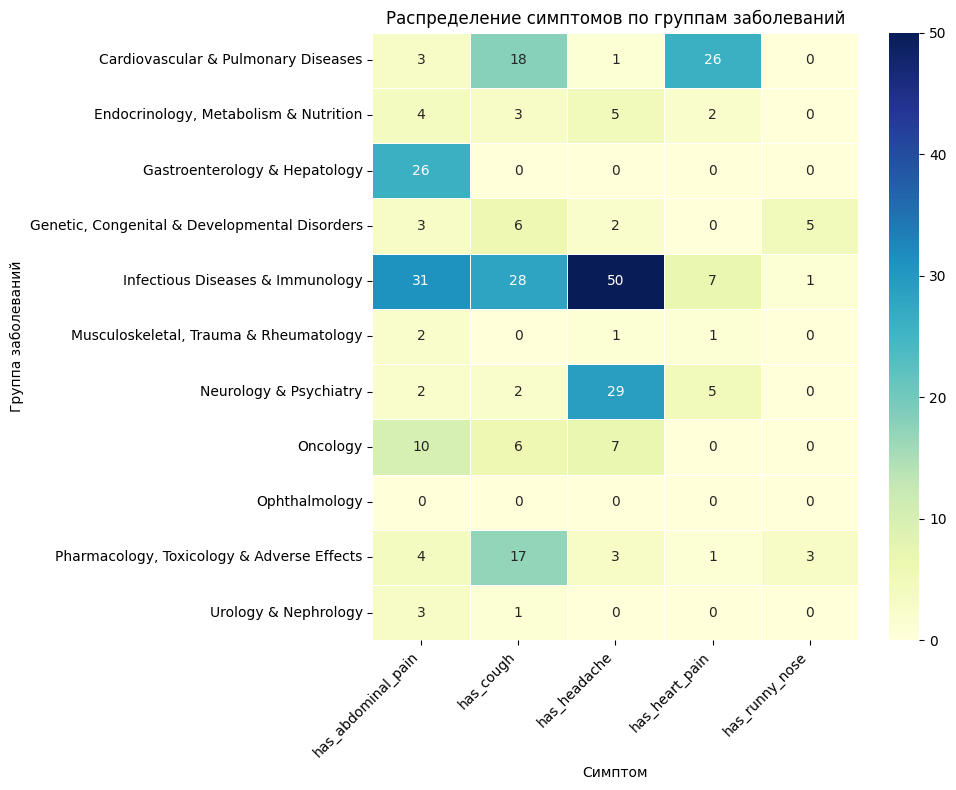

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Строим heatmap
plt.figure(figsize=(10, 8))  # Увеличиваем размер графика для лучшей читаемости
sns.heatmap(symptom_summary, annot=True, cmap='YlGnBu', fmt="d", linewidths=.5)
plt.title('Распределение симптомов по группам заболеваний')
plt.ylabel('Группа заболеваний')
plt.xlabel('Симптом')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи по оси x для лучшей читаемости
plt.tight_layout() # Улучшает размещение элементов графика
plt.show()

In [21]:
df_main_classified.columns

Index(['patient_id', 'patient_uid', 'PMID', 'file_path', 'title', 'patient',
       'age', 'gender', 'pub_date', 'Group', 'has_headache',
       'has_abdominal_pain', 'has_cough', 'has_runny_nose', 'has_heart_pain'],
      dtype='object')

In [22]:
df_main_classified.sample(50).values

array([[26300, '4387983-3', 25878904,
        'oa_comm/PMC004xxxxxx/PMC4387983.xml',
        'The Bipolar Depression Electrical Treatment Trial (BETTER): Design, Rationale, and Objectives of a Randomized, Sham-Controlled Trial and Data from the Pilot Study Phase',
        'Case 3 was a 48-year-old woman with bipolar depression type I. The depressive episode was of moderate severity. She had failed two antidepressant trials and one mood stabilizer treatment of adequate dose and duration, and at study entry she was drug-free. She did not present improvement of depressive symptoms (baseline and endpoint HDRS scores of 20 and 18, resp.).',
        list([[48.0, 'year']]), 'F', '2015', 'Neurology & Psychiatry',
        False, False, False, False, False],
       [30764, '4726507-5', 26808543,
        'oa_comm/PMC004xxxxxx/PMC4726507.xml',
        'Treatment Failure after Multiple Courses of Triclabendazole among Patients with Fascioliasis in Cusco, Peru: A Case Series',
        'Case 5 was a 

2025-12-16 10:05:27,271 - root - INFO - BlueCast blueprint initialized.
2025-12-16 10:05:27,271 - root - INFO - Start detecting and casting feature types.
2025-12-16 10:05:27,272 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-12-16 10:05:27,272 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-12-16 10:05:27,298 - root - INFO - Dropped the following columns as constants only: ['pub_month', 'pub_dayofyear'].
2025-12-16 10:05:27,298 - root - INFO - Dropped the following columns as constants only: ['pub_month', 'pub_dayofyear'].


Final shape: (1535, 268)
Classes: 11
Top classes:
 Group
Infectious Diseases & Immunology                 338
Oncology                                         231
Neurology & Psychiatry                           217
Genetic, Congenital & Developmental Disorders    196
Pharmacology, Toxicology & Adverse Effects       139
Cardiovascular & Pulmonary Diseases              117
Musculoskeletal, Trauma & Rheumatology            98
Ophthalmology                                     59
Gastroenterology & Hepatology                     54
Endocrinology, Metabolism & Nutrition             46
Name: count, dtype: int64


2025-12-16 10:05:27,578 - root - INFO - Start fitting target label encoder.
2025-12-16 10:05:27,580 - root - INFO - Start encoding target labels.
2025-12-16 10:05:27,581 - root - INFO - Start executing train-test split with train size of 0.8.
2025-12-16 10:05:27,584 - root - INFO - Start filling infinite values.
2025-12-16 10:05:27,585 - root - INFO - Start filling infinite values.
2025-12-16 10:05:27,586 - root - INFO - Start date column conversion.
2025-12-16 10:05:27,586 - root - INFO - Start date column conversion (transform).
2025-12-16 10:05:27,587 - root - INFO - Start fitting DataFrame schema.
2025-12-16 10:05:27,587 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-12-16 10:05:27,588 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-12-16 10:05:27,589 - root - INFO - Start fitting binary target encoder.
2025-12-16 10:05:27,589 - root - INFO - Start transforming categories wi

2025-12-16 10:14:04,304 - root - INFO - Finished training


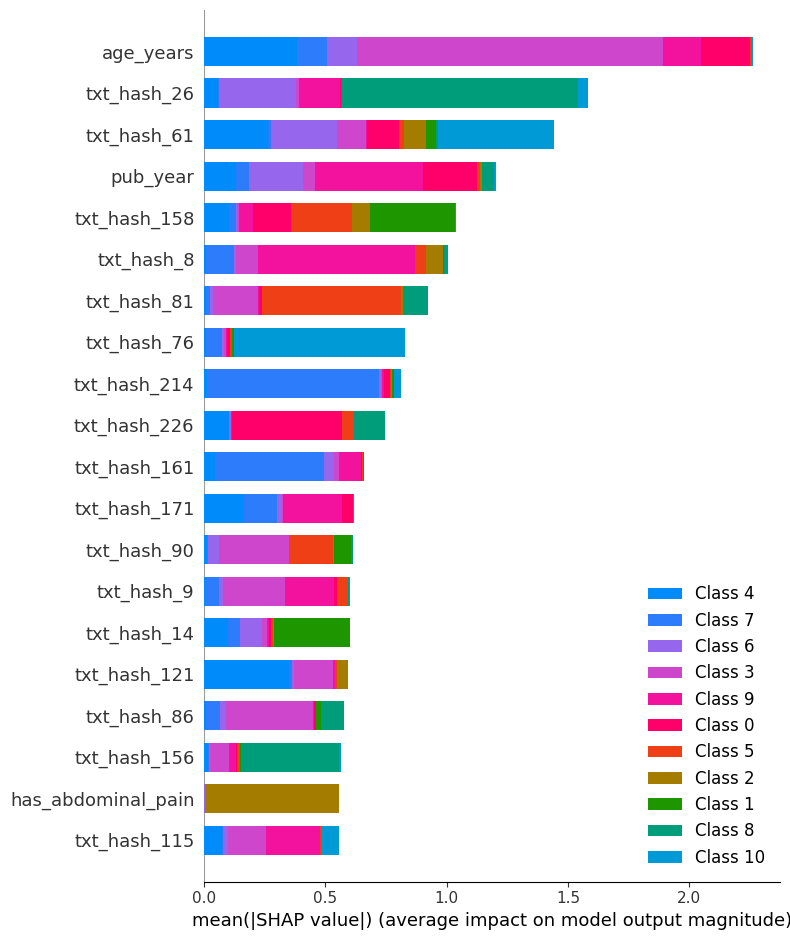

2025-12-16 10:14:07,832 - root - INFO - Plotting interactions of most important features by global SHAP values...
2025-12-16 10:14:07,835 - root - INFO - Start casting feature types.
2025-12-16 10:14:07,835 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-12-16 10:14:07,836 - root - INFO - Dropped the following columns as constants only: ['pub_month', 'pub_dayofyear'].
2025-12-16 10:14:07,836 - root - INFO - Start filling infinite values.
2025-12-16 10:14:07,837 - root - INFO - Start date column conversion (transform).
2025-12-16 10:14:07,837 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-12-16 10:14:07,838 - root - INFO - Start transforming categories with binary target encoder.
2025-12-16 10:14:07,838 - root - INFO - Start transforming categories with binary target encoder.
2025-12-16 10:14:07,840 - root - INFO - Predicting...
2025-12-16 10:14:07,840 - root - INFO - Start predicting on new data using Xg


--- HOLDOUT METRICS ---
Accuracy: 0.6156351791530945
Macro F1 : 0.6113849112348432

Classification report:
                                               precision    recall  f1-score   support

          Cardiovascular & Pulmonary Diseases      0.800     0.522     0.632        23
        Endocrinology, Metabolism & Nutrition      1.000     0.444     0.615         9
                Gastroenterology & Hepatology      0.800     0.364     0.500        11
Genetic, Congenital & Developmental Disorders      0.647     0.564     0.603        39
             Infectious Diseases & Immunology      0.500     0.794     0.614        68
       Musculoskeletal, Trauma & Rheumatology      0.875     0.700     0.778        20
                       Neurology & Psychiatry      0.543     0.581     0.562        43
                                     Oncology      0.696     0.696     0.696        46
                                Ophthalmology      0.538     0.583     0.560        12
   Pharmacology, Toxi

ValueError: 2

In [20]:
# =========================
# BlueCast multiclass baseline (FAST + CORRECT EVAL)
# =========================
# If needed:
# !pip install -U bluecast xgboost scikit-learn

import json
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import normalize

from bluecast.blueprints.cast import BlueCast
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig

# -------------------------
# 0) Helpers
# -------------------------
def _is_listlike(x) -> bool:
    return isinstance(x, (list, tuple, np.ndarray))

def parse_age_years(x):
    """
    Handles formats like:
      - [[67.0, 'year']]
      - [67.0, 'year']
      - 67
      - '67 years'
      - None / NaN
    Returns float years or NaN.
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan

    # list/tuple/array cases
    if _is_listlike(x):
        if len(x) == 0:
            return np.nan
        first = x[0]
        # nested: [[value, unit]]
        if _is_listlike(first) and len(first) >= 2:
            val, unit = first[0], first[1]
        # flat: [value, unit]
        elif len(x) >= 2 and not _is_listlike(first):
            val, unit = x[0], x[1]
        else:
            # just a list of numbers or something odd -> stringify
            s = str(x)
            m = re.search(r"(\d+(\.\d+)?)", s)
            return float(m.group(1)) if m else np.nan

        try:
            val = float(val)
        except Exception:
            return np.nan

        unit = str(unit).lower()
        if "month" in unit:
            return val / 12.0
        if "day" in unit:
            return val / 365.25
        # default: years
        return val

    # numeric scalar
    if isinstance(x, (int, float, np.number)):
        return float(x)

    # string
    s = str(x).lower()
    m = re.search(r"(\d+(\.\d+)?)", s)
    if not m:
        return np.nan
    val = float(m.group(1))
    if "month" in s:
        return val / 12.0
    if "day" in s:
        return val / 365.25
    return val

def stable_str(x):
    """Convert list/dict/unhashable stuff to stable string."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    if isinstance(x, (dict, list, tuple)):
        try:
            return json.dumps(x, ensure_ascii=False, sort_keys=True)
        except Exception:
            return str(x)
    return str(x)

def safe_predict(model, X_df):
    """
    Works across BlueCast versions:
    - tries return_original_labels=True if supported
    - otherwise decodes numeric classes via any accessible label encoder
    Returns: (probs, classes)
    """
    # Try native decoding if available
    try:
        out = model.predict(X_df, return_original_labels=True)  # per docs :contentReference[oaicite:3]{index=3}
    except TypeError:
        out = model.predict(X_df)

    # BlueCast commonly returns (y_probs, y_classes) :contentReference[oaicite:4]{index=4}
    if isinstance(out, tuple) and len(out) == 2:
        y_probs, y_classes = out
    else:
        y_probs, y_classes = None, out

    # If classes are numeric but you want original labels, try inverse_transform
    # (names differ between versions)
    if y_classes is not None:
        arr = np.asarray(y_classes)
        if np.issubdtype(arr.dtype, np.integer):
            for attr in ["target_label_encoder", "label_encoder", "target_encoder", "y_encoder"]:
                enc = getattr(model, attr, None)
                if enc is not None and hasattr(enc, "inverse_transform"):
                    try:
                        y_classes = enc.inverse_transform(arr)
                        break
                    except Exception:
                        pass

    return y_probs, y_classes



# -------------------------
# 1) Feature builder
# -------------------------
def build_features(df_raw: pd.DataFrame, text_cols=("title", "patient"), n_text_features=256) -> pd.DataFrame:
    df = df_raw.copy()

    # --- Target must exist
    assert "Group" in df.columns, "Need target column 'Group' in df."

    # --- Age
    if "age" in df.columns:
        df["age_years"] = df["age"].apply(parse_age_years).astype("float32")

    # --- Date -> numeric
    if "pub_date" in df.columns:
        dt = pd.to_datetime(df["pub_date"], errors="coerce")
        df["pub_year"] = dt.dt.year.astype("float32")
        df["pub_month"] = dt.dt.month.astype("float32")
        df["pub_dayofyear"] = dt.dt.dayofyear.astype("float32")

    # --- Simple gender encoding if present
    if "gender" in df.columns:
        g = df["gender"].astype(str).str.upper().str.strip()
        df["gender_code"] = g.map({"M": 0, "F": 1}).fillna(-1).astype("int16")

    # --- Text hashing features (fast, no fitting)
    # Combine any available text columns
    parts = []
    for c in text_cols:
        if c in df.columns:
            parts.append(df[c].apply(stable_str))
    if parts:
        text = parts[0]
        for p in parts[1:]:
            text = text + " " + p

        df["text_len"] = text.str.len().astype("int32")

        hv = HashingVectorizer(
            n_features=n_text_features,
            alternate_sign=False,
            norm=None,
            ngram_range=(1, 2),
            lowercase=True
        )
        X_txt = hv.transform(text.fillna(""))
        # l2 normalize rows; helps a bit for hashing features
        X_txt = normalize(X_txt, norm="l2", copy=False)
        X_txt = X_txt.astype(np.float32).toarray()

        txt_cols = [f"txt_hash_{i}" for i in range(n_text_features)]
        df_txt = pd.DataFrame(X_txt, columns=txt_cols, index=df.index)
        df = pd.concat([df, df_txt], axis=1)

    # --- Drop obvious leakage / ids / raw text
    drop_if_exists = [
        "patient_id", "patient_uid", "PMID", "file_path",
        "title", "patient", "pub_date", "age"
    ]
    df = df.drop(columns=[c for c in drop_if_exists if c in df.columns], errors="ignore")

    # --- Ensure predictors are numeric only (avoid your 'unhashable list' nightmare)
    y = df["Group"].astype(str)
    X = df.drop(columns=["Group"])

    # Convert bool -> int
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype("int8")

    # Drop non-numeric leftovers aggressively (better than silently poisoning training)
    nonnum = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if nonnum:
        # If you REALLY want them, encode separately. For now: drop.
        X = X.drop(columns=nonnum)

    out = X.copy()
    out["Group"] = y
    return out

# =========================
# 2) Prepare data
# =========================
# EXPECTATION: df_main_classified is already in memory
# Must contain column "Group" + whatever predictors you have.
df_feat = build_features(df_main_classified, text_cols=("title", "patient"), n_text_features=256)

X = df_feat.drop(columns=["Group"])
y = df_feat["Group"].astype(str)

print("Final shape:", df_feat.shape)
print("Classes:", y.nunique())
print("Top classes:\n", y.value_counts().head(10))

# Holdout split (stratify is important if class imbalance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=33,
    stratify=y if y.nunique() > 1 else None
)

train_df = X_train.copy()
train_df["Group"] = y_train
val_df = X_val.copy()

# =========================
# 3) BlueCast config (FAST)
# =========================
xgb_conf = XgboostTuneParamsConfig()
# Even if autotune is off, keep this conservative (won't hurt)
xgb_conf.steps_max = 50

train_conf = TrainingConfig()
train_conf.autotune_model = False                 # key: no Optuna tuning :contentReference[oaicite:5]{index=5}
train_conf.hyperparameter_tuning_rounds = 0
train_conf.hypertuning_cv_folds = 1               # avoid multiplying runtime by folds :contentReference[oaicite:6]{index=6}
train_conf.use_full_data_for_final_model = False  # IMPORTANT for honest holdout evaluation

model = BlueCast(
    class_problem="multiclass",
    conf_training=train_conf,
    conf_xgboost=xgb_conf
)

# =========================
# 4) Train
# =========================
model.fit(train_df, target_col="Group")

# =========================
# 5) Predict + CORRECT evaluation
# =========================
y_probs, y_pred = safe_predict(model, val_df)

print("\n--- HOLDOUT METRICS ---")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Macro F1 :", f1_score(y_val, y_pred, average="macro"))

print("\nClassification report:")
print(classification_report(y_val, y_pred, digits=3))

# Optional: quick sanity check (what labels are we predicting?)
print("\nPred sample:", list(pd.Series(y_pred).astype(str).head(10)))
print("True sample:", list(y_val.astype(str).head(10)))


In [21]:
# y_pred can be (n,1) or (n,) — make it flat 1D
y_pred = np.asarray(y_pred)
if y_pred.ndim > 1:
    y_pred = y_pred.reshape(-1)

# (optional) also ensure y_val is 1D array
y_val_arr = np.asarray(y_val).reshape(-1)

print("\nPred sample:", list(pd.Series(y_pred).astype(str).head(10)))
print("True sample:", list(pd.Series(y_val_arr).astype(str).head(10)))


Pred sample: ['Oncology', 'Infectious Diseases & Immunology', 'Infectious Diseases & Immunology', 'Infectious Diseases & Immunology', 'Neurology & Psychiatry', 'Neurology & Psychiatry', 'Musculoskeletal, Trauma & Rheumatology', 'Infectious Diseases & Immunology', 'Neurology & Psychiatry', 'Neurology & Psychiatry']
True sample: ['Oncology', 'Pharmacology, Toxicology & Adverse Effects', 'Infectious Diseases & Immunology', 'Infectious Diseases & Immunology', 'Neurology & Psychiatry', 'Genetic, Congenital & Developmental Disorders', 'Musculoskeletal, Trauma & Rheumatology', 'Infectious Diseases & Immunology', 'Oncology', 'Neurology & Psychiatry']
